## Matched Filtering in Action for Real LIGO Data
This tutorial is based on [Tutorial 2.2](https://github.com/gw-odw/odw-2020/blob/master/Day_2/Tuto_2.2_Matched_Filtering_In_action.ipynb) from the GW Open Data Workshop \#3.

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. In the last tutorial, we explored the underlying concept behind matched-filtering--the cross-correlation--and performed this operation ourselves in the time domain for simulated Gaussian noise. In this tutorial, we will use prebuilt PyCBC methods to perform the matched filtering using real LIGO data around the first detection, GW150914.

## Installation (execute only if running on a cloud platform!)

In [1]:
# -- Use the following for Google Colab
#! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Looking for a specific signal in the data

If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method in Gaussian noise to extract the signal. Even when the parameters of the signal are unkown, you can perform the matched filtering and calculate the SNR for a range of different parameter values across the space of interest, and the template that maximizes the SNR will be the one with the parameters closest to the signal.

### Preconditioning the data 
 
Since we aren't using simulated Gaussian noise anymore, we now need to precondition the data before trying to perform the matched filtering to supress low freqeuncy behavior which can introduce numerical artefacts. We will use a **high-pass** filter to remove frequency content below 15 Hz, where we know the LIGO data is affected by seismic noise. We may also wish to reduce the sample rate of the data if high frequency content is not important. PyCBC contains an interface to the online catalog of gravitational-wave data and events, so you can easily access the data and parameters of the published gravitational-wave signals

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


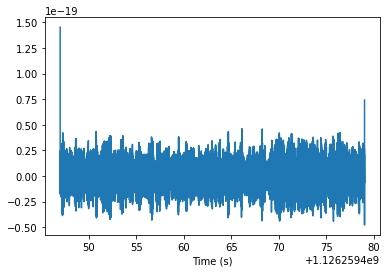

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.show()

#### Filter wraparound 

Note the spike in the data at the boundaries. This is caused by the highpass filter applied to the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. This causes issues becasue the data are not periodic. To avoid this, we trim the ends of the data sufficiently to remove the spikes.

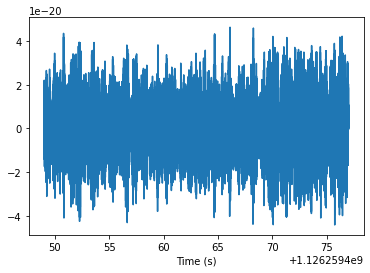

In [4]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')
plt.show()

### Calculate the power spectral density
As we saw in the previous notebook, one of the key steps for calculating the cross-correlation between the data and the template is to "whiten" both of them. To do this, we need to calculate the PSD. We can use the built-in method from PyCBC to do this, as before. Since we are using real data instead of a theoretical model for the PSD, we need to apply some extra conditioning steps to make sure the PSD is well-behaved.

In [5]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

Add a cell below and plot the PSD to make sure it looks as expected. Remember that you can get the frequencies associated with the PSD object by using `psd.sample_frequencies`. What is happening at low frequencies?

### Create the template
As we saw previously, matched filtering involves computing the cross-correlation between the potential signal, or template, and the data by sliding the template across the data and summing over the product of the two.
If there is a signal in the data that aligns with the template, you will get a large value of the cross-correlation. Let's use PyCBC to calculate our template waveform.

In [7]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 
m = 36 # Solar masses
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

When we first looked at waveforms, we learned that the merger of the two black holes occurs approximately at the time corresponding to the maximum amplitude of the waveform. In the previous example of matched filtering simulated data, the peak of our cross-correlation did not occur at the time of the merger. Rather, it occured at the time corresponding to the _start_ of the signal hidden in the data. To get a better estimate of the merger time instead of the start of the signal, we need to shift the location of the merger to the end of the template. We do this below using the `cyclic_time_shift` method.

Text(0, 0.5, 'h(t)')

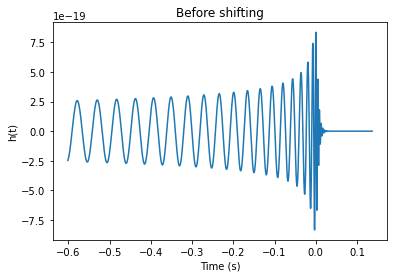

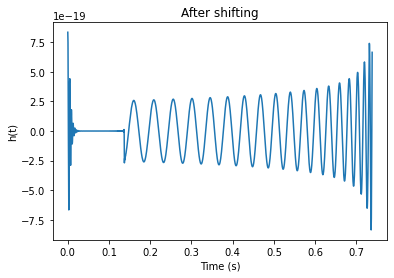

In [8]:
plt.figure()
plt.title('Before shifting')
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('h(t)')

template = hp.cyclic_time_shift(hp.start_time)

plt.figure()
plt.title('After shifting')
plt.plot(template.sample_times, template)
plt.xlabel('Time (s)')
plt.ylabel('h(t)')

### Calculating the cross-correlation and signal-to-noise time series
Now we will use the tools we developed in the last notebook to calculate the cross-correlation between the data and the template. Previosuly, we used the maximum of the cross-correlation to calculate the SNR with which the signal is detected. We can actually calculate the SNR for all the elements of the cross-correlation array to see how it changes in time. The formula is the same, just applied to the whole array instead of just the maximum. This is called the **SNR timeseries**.

We found a signal at 1126259463.573723007s with SNR 13.063504750814415


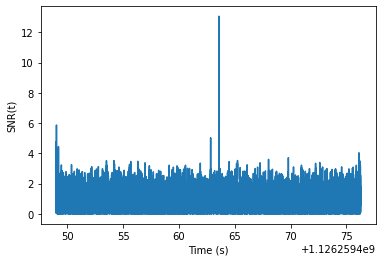

In [9]:
# The PSD, sampled properly for the signal
psd_template = interpolate(psd, template.delta_f)

# Whiten both the conditioned data and the template
conditioned_whitened = (conditioned.to_frequencyseries() / (psd)**0.5).to_timeseries()
template_whitened = (template.to_frequencyseries() / (psd_template[:-1])**0.5).to_timeseries()
templaten = template_whitened.numpy()
conditionedn = conditioned_whitened.numpy()

# Calculate the cross-correlation, times, and SNR
cc = np.correlate(templaten, conditionedn)
n_shift = len(conditionedn) - len(templaten)
dt = conditioned.delta_t
times = np.arange(conditioned.start_time, conditioned.start_time + n_shift*dt + dt, dt)
snr = np.absolute(cc)/np.std(cc)

# Plot the SNR timeseries
plt.plot(times, snr)
plt.xlabel('Time (s)')
plt.ylabel('SNR(t)')
peak = np.argmax(snr)
print("We found a signal at {}s with SNR {}".format(times[peak], snr[peak]))

### Using PyCBC to calculate the SNR timeseries
It turns our that there is a handy PyCBC function that can calcualte the SNR timeseries for us, which does the whitening and cross-correlation under the hood. The only difference from above is that the template needs to be the same size as the data, rather than shorter. We can get around this by "resizing" the template to match the data length. This amounts to adding a bunch of zeros after the end of the actual template.

In [10]:
from pycbc.filter import matched_filter, matched_filter_core

# Make our new, longer template
hp2, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
hp2.resize(len(conditioned))
template2 = hp2.cyclic_time_shift(hp2.start_time)

# Calculate the SNR
snr = matched_filter(template2, conditioned, psd=psd, low_frequency_cutoff=20)

Looking at our plot of the SNR timeseries above, we can also see some spikes at times near the beginning and end of the segment. These are artifacts from filtering that we can safely remove. We also need to take the absolute value like we did above, since PyCBC doesn't do this step for us.

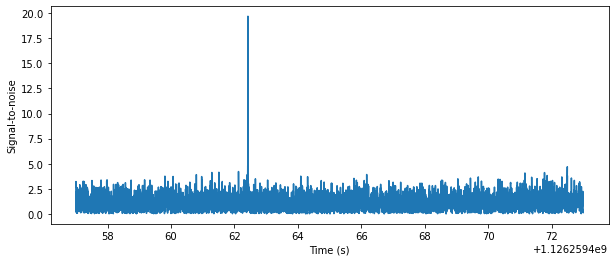

We found a signal at 1126259462.4248047s with SNR 19.678977177701515


In [11]:
# Remove problematic times
snr = snr.crop(4 + 4, 4)

# Take absolute value and plot
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

How do the time and SNR of the peak calculated with PyCBC compare with what we calculated above? The times match to within a second, but the SNR calculated by PyCBC is a bit higher. There are some extra corrections that need to be taken into account for properly normalizing the calculation and aligning the template and waveform. For this reason, we'll use the PyCBC version from now on.

### Aligning and Subtracting the Proposed Signal

In the previous section we found a peak in the signal-to-noise for a proposed binary black hole merger. We can use this SNR peak to align our template to the data, and to also subtract our template from the data. The data should be Gaussian after the signal is subtracted, as we'll be left with pure noise.

In [12]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template2.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

### Visualize the overlap between the signal and data

To compare the data and signal on equal footing, and to concentrate on the frequency range that is important, we will whiten both the template and the data, and then **bandpass** both the data and template between 30-300 Hz. This just means that we will remove frequencies in this range. In this way, any signal that is in the data is transformed in the same way that the template is.

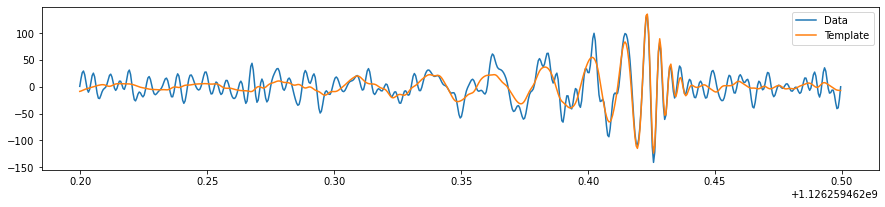

In [13]:
# Whiten
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

# Remove excess frequencies
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.legend()
plt.show()

Similar to how we were able to see the spike in the whitened timseries in our simulated data, we can see the signal by eye in the whitened data for GW150914, too! It matches very closely with the whitened signal. The extra wiggles in the blue are just due to noise fluctuations. 

#### Subtracting the signal from the data

Now that we've aligned the template we can simply subtract it. Let's see below how that looks in the time-frequency plots! Here the x-axis is time and the y-axis is frequency. The color corresponds to the strenght of the signal. We can see clearly the trend that the frequency of the signal increases in time. This is the characteristic "chirp" for binary black holes.

<ipython-input-14-485b6bae4c8b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)


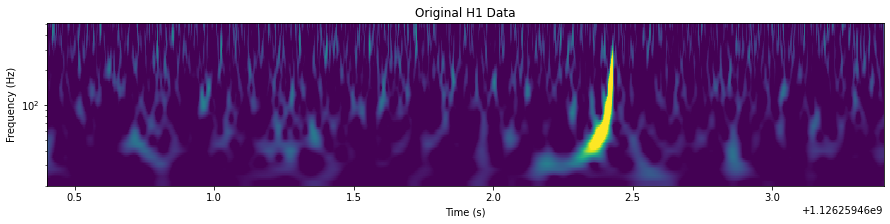

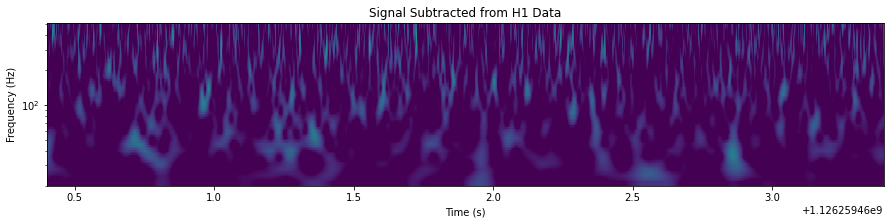

In [14]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)
    plt.show()

## Challenge!

Use the methods demonstrated above to see if you can calculate the SNR
time series in the following data sets. What is the SNR of each signal?
Which template matched best to which data?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass1 (equal mass) and that each component mass is one of 15, 30, or 45.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [15]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://github.com/gw-odw/odw-2020/raw/master/Data/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf']

for fname in files:
    get_file(fname)    

# An example of how to read the data from these files:
file_name = "PyCBC_T2_0.gwf"

# A channel name is needed since often `gwf` files contain 
# many different data sets.
channel_name = "H1:TEST-STRAIN"

start = 0
end = start + 128

ts = read_frame(file_name, channel_name, start, end)

Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_0.gwf
Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_1.gwf
Getting : https://github.com/gw-odw/odw-2020/raw/master/Data/PyCBC_T2_2.gwf
